# **MACHINE TRANSLATION**

En está práctica se va a implementar un traductor de español a inglés comparando diferentes técnicas. 

Para ello, se va a utilizar un corpus de la página web http://www.manythings.org/anki/ correspondiente a los idiomas que se quieren tratar. A estos datos de entrada se les van a aplicar una serie de funciones para limpiar los datos antes de introducirlos en nuestro modelo.

Se van a introducir los datos en tres modelos diferentes basados en Redes Neuronales Recurrentes (RNN - Recurrent Neural Networks): SimpleRNN, LSTM y GRU. Además, se va a utilizar una arquitectura basada en Seq2Seq debido a que queremos transformar una secuencia en otra.

## Tabla de Contenidos

1. [Librerías](#lib)


2. [Lectura y preparación datos](#datos)
    
    2.1. [Carga de datos](#carga)

    2.2. [Limpieza del texto](#limpieza)

    2.3. [Tokenización del texto](#token)
    
    
3. [Creación de modelos](#modelos)

    3.1. [Modelo por defecto](#def)

    3.2. [LSTM](#lstm)

    3.3. [SimpleRNN](#simple)

    3.4. [GRU](#gru)
    
    
4. [Conclusiones](#conclusiones)

<a id="lib"></a>
## Librerías

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/MACHINE TRANSLATION

# List project directory contents
!ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/MACHINE TRANSLATION
 acc_model_h1_05_may_20.png
 acc_model_h1_05_may_20_v2.png
'Copia de Copia de Copia de MCastaneda_LAB_TEXT_MachineTranslation_EN_ES.ipynb'
'Copia de Copia de MCastaneda_LAB_TEXT_MachineTranslation_EN_ES.ipynb'
'Copia de MCastaneda_LAB_TEXT_MachineTranslation_EN_ES.ipynb'
 deu-eng
 LAB_TEXT_MachineTranslation_DE_EN.ipynb
 loss_model_GRU_RNN.png
 loss_model_h1_05_may_20.PNG
 loss_model_h1_05_may_20_v2.png
 loss_model_S

In [0]:
!ls spa-eng/

_about.txt  spa.txt


In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


<a id="datos"></a>
## Lectura y preparación datos

Función para leer los datos:

In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Función para separar las parejas de texto Español-Inglés por lineas y frases.

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

Función para tokenizar:

In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

Función para codificar (seq + pad):

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

Se cargan los datos y aplicamos las funciones para realizar el pre-procesado del texto (limpieza, tokenización y conversión a secuencia)

<a id="carga"></a>
### Carga de datos

In [0]:
data = read_text("spa-eng/spa.txt")

<a id="limpieza"></a>
### Limpieza del texto

In [0]:
spa_eng = to_lines(data)
spa_eng = array(spa_eng)

# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()

<a id="token"></a>
### Tokenización del texto

Primero, se va a observar la longitud de las frases tanto en español como en inglés:

        eng  spa
0         1    1
1         1    1
2         1    1
3         1    1
4         1    1
...     ...  ...
123765   31   35
123766   34   42
123767   34   35
123768   43   44
123769   47   49

[123770 rows x 2 columns]
47
49
47


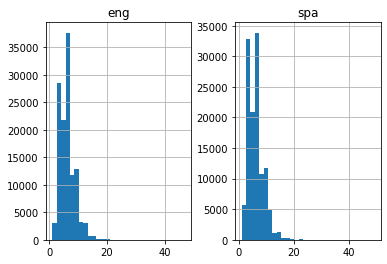

In [9]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split())) # length each sentence --> English 

for i in spa_eng[:,1]:
    spa_l.append(len(i.split())) # length each sentence --> Spanish


length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l}) # juntamos las longitudes de una frase en inglés con su correspondiente en español
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))
print(min(max(length_df.eng),max(length_df.spa)))

length_df.hist(bins = 30)
plt.show()

Se han generado dos histogramas, uno por cada idioma, que indican la frecuencia de cada una de las longitudes que aparecen en nuestro set de datos.



*   En el caso del correspondiente al inglés, las longitudes oscilan de 1 a 47 palabras, siendo en torno a 7 palabras la más frecuente.
*   En cuanto al español, las longitudes tienen un rango de 1 a 49 palabras. En este caso, las más frecuentes se encuentran entre 5 y 7 palabras.

A continuación, se van a vectorizar nuestros datos de texto empleando el Tokenizer() de Keras. De esta manera, se transformarán nuestras frases en secuencias de enteros (integers). Tras ello, se rellenarán dichas secuencias con ceros para que todas las secuencias tengan la misma longitud (padding).

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = min(max(length_df.eng),max(length_df.spa))

# Traducción al inglés, cojo este valor como referencia. Ponemos spa_length y eng_length iguales porque queremos que el input y el output sea igual. Para hacerlo más sencillo.
print('English Vocabulary Size: %d' % eng_vocab_size)

# prepare Spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = min(max(length_df.eng),max(length_df.spa))
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

print(spa_tokenizer.word_counts)

English Vocabulary Size: 13740
Spanish Vocabulary Size: 27497
OrderedDict([('ve', 231), ('vete', 39), ('vaya', 170), ('váyase', 8), ('hola', 22), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 3), ('¿quién', 610), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 4), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 12), ('continúa', 21), ('continúe', 8), ('me', 8332), ('oculté', 1), ('escondí', 6), ('ocultaba', 1), ('escondía', 4), ('corrí', 19), ('corría', 11), ('lo', 6977), ('intento', 34), ('¡he', 2), ('ganado', 38), ('¡oh', 9), ('no', 20703), ('tomátelo', 2), ('con', 4955), ('soda', 4), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 12), ('¡al', 3), ('ataque', 26), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 42), ('ahora', 1110), ('mismo', 568), ('id', 8), ('vayan', 24), ('ya', 107

<a id="modelos"></a>
## Creación de modelos

Ahora, se va a separar el dataset en un conjunto de entrenamiento (80%) y otro de validación (20%).

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

Codificación de las frases (encode). Las frases en Español corresponden a las secuencias de entrada y las de Inglés a las secuencias que se desean obtener a partir de las anteriores. Se realiza tanto para el conjunto de entrenamiento como para el de test.

In [12]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

print(trainX.shape)
print(trainY.shape)

# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

print(testX.shape)
print(testY.shape)

[[3146    7 8209 ...    0    0    0]
 [ 173    1 4740 ...    0    0    0]
 [ 325 1174   25 ...    0    0    0]
 ...
 [  11 6678    7 ...    0    0    0]
 [   5 2769  556 ...    0    0    0]
 [  80    2  173 ...    0    0    0]]
99016
[[   2  194    1 ...    0    0    0]
 [   4 1025    3 ...    0    0    0]
 [  14    4   18 ...    0    0    0]
 ...
 [   4  456   17 ...    0    0    0]
 [   5    7  148 ...    0    0    0]
 [   2   59    4 ...    0    0    0]]
99016
(99016, 47)
(99016, 47)
[[2328 1062   20 ...    0    0    0]
 [ 221   73 1733 ...    0    0    0]
 [   5   21  688 ...    0    0    0]
 ...
 [  34 9651    0 ...    0    0    0]
 [   7  488  200 ...    0    0    0]
 [   5   12 4330 ...    0    0    0]]
24754
[[   2  347    3 ...    0    0    0]
 [  65   46   27 ...    0    0    0]
 [   5    7  442 ...    0    0    0]
 ...
 [  32 4535    0 ...    0    0    0]
 [   1 1694  231 ...    0    0    0]
 [   5 2420  367 ...    0    0    0]]
24754
(24754, 47)
(24754, 47)


A continuación, se va a definir la arquitectura del modelo Seq2Seq. Vamos a emplear una capa de Embedding así como una del algoritmo (simpleRNN, LSTM o GRU) como encoder, y otra más seguida por una capa Dense como decoder.

Esto se va a realizar para los 3 tipos de modelos que se desean comparar.

Se han cambiado los hiperparametros a 15 épocas (epochs) y un tamaño de lote de 32 (batch size).


<a id="def"></a>
### Modelo por defecto

In [0]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model.h1.05_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 64000 samples, validate on 16000 samples
Epoch 1/30
64000/64000 [==============================] - 53s 821us/step - loss: 3.5014 - val_loss: 3.1292

Epoch 00001: val_loss improved from inf to 3.12921, saving model to model.h1.05_may_20
Epoch 2/30
64000/64000 [==============================] - 52s 805us/step - loss: 3.0237 - val_loss: 2.9205

Epoch 00002: val_loss improved from 3.12921 to 2.92045, saving model to model.h1.05_may_20
Epoch 3/30
64000/64000 [==============================] - 51s 802us/step - loss: 2.8653 - val_loss: 2.8637

Epoch 00003: val_loss improved from 2.92045 to 2.86372, saving model to model.h1.05_may_20
Epoch 4/30
64000/64000 [==============================] - 51s 803us/step - loss: 2.7057 - val_loss: 2.6621

Epoch 00004: val_loss improved from 2.86372 to 2.66210, saving model to model.h1.05_may_20
Epoch 5/30
64000/64000 [==============================] - 51s 803us/step - loss: 2.5188 - val_loss: 2.5338

Epoch 00005: val_loss improved from 2.66210 to 2.5

**Loss**

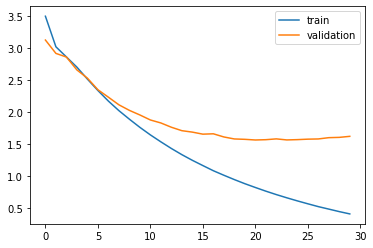

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
plt.savefig("loss_model_h1_05_may_20.png")

<a id="lstm"></a>
### LSTM

**Entrenamiento**

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# build NMT model
def model_LSTM_2(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
model_LSTM = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32) #512)
rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model_LSTM.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model_LSTM_15EPOCHS_32BATCH'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_LSTM = model_LSTM.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size= 32, #512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79212 samples, validate on 19804 samples
Epoch 1/15
79212/79212 [==============================] - 697s 9ms/step - loss: 1.1074 - acc: 0.8718 - val_loss: 0.8455 - val_acc: 0.8756

Epoch 00001: val_loss improved from inf to 0.84547, saving model to model_LSTM_15EPOCHS_32BATCH
Epoch 2/15
79212/79212 [==============================] - 688s 9ms/step - loss: 0.8251 - acc: 0.8779 - val_loss: 0.8147 - val_acc: 0.8794

Epoch 00002: val_loss improved from 0.84547 to 0.81474, saving model to model_LSTM_15EPOCHS_32BATCH
Epoch 3/15
79212/79212 [==============================] - 685s 9ms/step - loss: 0.7983 - acc: 0.8814 - val_loss: 0.7919 - val_acc: 0.8826

Epoch 00003: val_loss improved from 0.81474 to 0.79186, saving model to model_LSTM_15EPOCHS_32BATCH
Epoch 4/15
79212/79212 [==============================] - 682s 9ms/step - loss: 0.7730 - acc: 0.8843 - val_loss: 0.7732 - val_acc: 0.8849

Epoch 00004: val_loss improved from 0.79186 to 0.77318, saving model to model_LSTM_15EPOCHS_32BATC

**Loss**

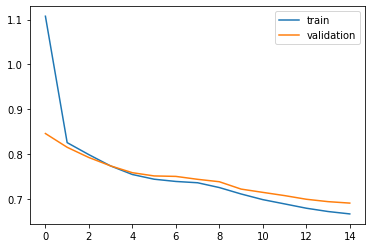

In [0]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Accuracy**

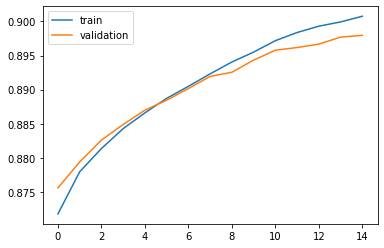

In [0]:
plt.plot(history_LSTM.history['acc'])
plt.plot(history_LSTM.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

**Prueba añadiendo otra capa LSTM**

In [0]:
model_LSTM_2 = model_LSTM_2(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32) #512)
rms = optimizers.RMSprop(lr=0.001)
# model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
model_LSTM_2.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model_LSTM_15EPOCHS_32BATCH_2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_LSTM_2 = model_LSTM_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size= 32, #512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79212 samples, validate on 19804 samples
Epoch 1/15
79212/79212 [==============================] - 960s 12ms/step - loss: 1.1053 - acc: 0.8717 - val_loss: 0.8572 - val_acc: 0.8739

Epoch 00001: val_loss improved from inf to 0.85717, saving model to model_LSTM_15EPOCHS_32BATCH_2
Epoch 2/15
79212/79212 [==============================] - 961s 12ms/step - loss: 0.8397 - acc: 0.8752 - val_loss: 0.8313 - val_acc: 0.8756

Epoch 00002: val_loss improved from 0.85717 to 0.83126, saving model to model_LSTM_15EPOCHS_32BATCH_2
Epoch 3/15
79212/79212 [==============================] - 957s 12ms/step - loss: 0.8174 - acc: 0.8776 - val_loss: 0.8150 - val_acc: 0.8782

Epoch 00003: val_loss improved from 0.83126 to 0.81505, saving model to model_LSTM_15EPOCHS_32BATCH_2
Epoch 4/15
79212/79212 [==============================] - 968s 12ms/step - loss: 0.7985 - acc: 0.8800 - val_loss: 0.7947 - val_acc: 0.8812

Epoch 00004: val_loss improved from 0.81505 to 0.79472, saving model to model_LSTM_15EPO

**Loss**

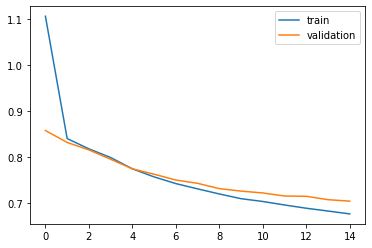

In [0]:
plt.plot(history_LSTM_2.history['loss'])
plt.plot(history_LSTM_2.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

**Accuracy**

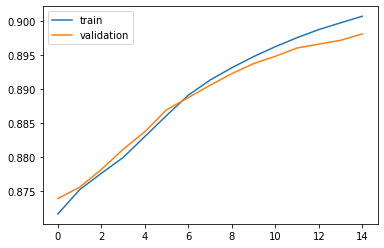

In [0]:
plt.plot(history_LSTM_2.history['acc'])
plt.plot(history_LSTM_2.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

**Predicciones**

Cargamos el modelo para realizar predicciones:

In [0]:
model_LSTM = load_model('model_LSTM_15EPOCHS_32BATCH')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
print(testX.shape[0])
print(testX.shape[1])

24754
47


In [0]:
preds_LSTM = model_LSTM.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds_LSTM:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual_spa': test[:,1], 'actual_eng' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [0]:
pred_df.sample(15)

,actual_spa,actual_eng,predicted
16984,soy un traductor,i am a translator,i am a man
8079,hablo francés con tom y mary,i speak french with tom and mary,i speak french and mary
10435,todo parecía normal,everything seemed normal,everyone seemed
3249,él fingió ser mi amigo,he pretended to be my friend,he pretended to be my friend
8339,este libro es muy útil,this book is of great use,this book is very useful
14473,vengo de entregar mi solicitud,i just turned in my application,i come with my ill
19803,me hizo sonreír,it made me smile,he made me smile
14110,¿eres tú,is it you,are you
16077,por favor no se moleste,please dont bother,please dont bother yourself
7988,es el consejero de mayor confianza del rey,hes the kings most trusted advisor,he is the tallest of his king


In [0]:
# pred_df.tail(15)

In [0]:
pred_df.head(15)

,actual_spa,actual_eng,predicted
0,¿qué leéis,whatre you reading,what are you reading
1,los estudiantes están en recreo ahora,the students are having a recess now,the students are now
2,¿dónde conseguiste esta lista,where did you get this list,where will you go this
3,las cosas cambiaron,things changed,all do work
4,mi hijo quiere ser un golfista profesional,my son wants to be a professional golfer,my man wants to be a
5,todos lo admiraban,everybody looked up to him,everyone all it
6,el suelo está frío,the floor is cold,the cold is cool
7,ayer terminé el trabajo,i finished the work yesterday,yesterday finished the job yesterday
8,¿qué tiene que ver eso conmigo,what has that to do with me,what does he have to do with
9,tom llega temprano,toms early,tom is early


<a id="simple"></a>
### SimpleRNN

In [0]:
# build NMT model
def build_model_2(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    #model.add(SimpleRNN(units))
    #model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units,return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
# build NMT model
def model_simpleRNN_2(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(SimpleRNN(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(SimpleRNN(units,return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [0]:
eng_vocab_size

13740

In [0]:
model_SimpleRNN = build_model_2(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32) #512)
rms = optimizers.RMSprop(lr=0.001)
model_SimpleRNN.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model_SimpleRNN_15EPOCHS_32BATCH'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_SimpleRNN = model_SimpleRNN.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=32, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79212 samples, validate on 19804 samples
Epoch 1/15
79212/79212 [==============================] - 232s 3ms/step - loss: 0.7425 - acc: 0.1457 - val_loss: 0.6806 - val_acc: 0.2081

Epoch 00001: val_loss improved from inf to 0.68056, saving model to model_SimpleRNN_15EPOCHS_32BATCH
Epoch 2/15
79212/79212 [==============================] - 230s 3ms/step - loss: 0.6574 - acc: 0.2446 - val_loss: 0.6410 - val_acc: 0.2701

Epoch 00002: val_loss improved from 0.68056 to 0.64101, saving model to model_SimpleRNN_15EPOCHS_32BATCH
Epoch 3/15
79212/79212 [==============================] - 228s 3ms/step - loss: 0.6254 - acc: 0.2853 - val_loss: 0.6195 - val_acc: 0.2925

Epoch 00003: val_loss improved from 0.64101 to 0.61951, saving model to model_SimpleRNN_15EPOCHS_32BATCH
Epoch 4/15
79212/79212 [==============================] - 232s 3ms/step - loss: 0.6060 - acc: 0.3059 - val_loss: 0.6054 - val_acc: 0.3086

Epoch 00004: val_loss improved from 0.61951 to 0.60540, saving model to model_Simpl

**Loss**

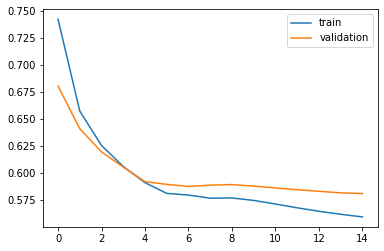

<Figure size 432x288 with 0 Axes>

In [0]:
plt.plot(history_SimpleRNN.history['loss'])
plt.plot(history_SimpleRNN.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
plt.savefig("loss_model_SimpleRNN.png")

**Accuracy**

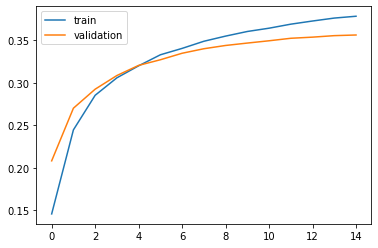

In [0]:
plt.plot(history_SimpleRNN.history['acc'])
plt.plot(history_SimpleRNN.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

In [0]:
model_SimpleRNN_2 = model_simpleRNN_2(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32) #512)
rms = optimizers.RMSprop(lr=0.001)
model_SimpleRNN_2.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model_SimpleRNN_15EPOCHS_32BATCH_2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_SimpleRNN_2 = model_SimpleRNN_2.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=32, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

**Predicciones**

In [0]:
model_SimpleRNN = load_model('model_SimpleRNN_15EPOCHS_32BATCH')
preds_SimpleRNN = model_SimpleRNN.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

# convert predictions into text (English)
preds_text_SimpleRNN = []
for i in preds_SimpleRNN:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text_SimpleRNN.append(' '.join(temp))

pred_df_SimpleRNN = pd.DataFrame({'actual_spa': test[:,1], 'actual_eng' : test[:,0], 'predicted' : preds_text_SimpleRNN})
pd.set_option('display.max_colwidth', 200)

pred_df_SimpleRNN.sample(15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


,actual_spa,actual_eng,predicted
13905,ahora es mi turno,now its my turn,now my turn
18893,nunca tomo té con leche,i never drink tea with milk,i never drink milk drink milk
1232,en cuanto a mí no tengo objeción,as for me i have no objection,at it dont i to you
10363,un accidente puede ocurrir sin previo aviso,an accident may happen at any time,a may come from once
7184,no fue encontrado,it wasnt found,we didnt found
1018,hoy ha sido un día agotador,today was a tiring day,it has a today
12894,¿cuántas personas son,how many are in your party,how many people do you
1296,derramé mi café sobre la alfombra,i spilled my coffee on the carpet,i made your name of my opinion
5597,mi equipaje se extravió,my luggage got lost,my is been
19009,tom vio a mary sonreír a john,tom saw mary smiling at john,tom saw mary john


In [0]:
pred_df.head(15)

,actual_spa,actual_eng,predicted
0,¿qué leéis,whatre you reading,what are you reading
1,los estudiantes están en recreo ahora,the students are having a recess now,the students are now
2,¿dónde conseguiste esta lista,where did you get this list,where will you go this
3,las cosas cambiaron,things changed,all do work
4,mi hijo quiere ser un golfista profesional,my son wants to be a professional golfer,my man wants to be a
5,todos lo admiraban,everybody looked up to him,everyone all it
6,el suelo está frío,the floor is cold,the cold is cool
7,ayer terminé el trabajo,i finished the work yesterday,yesterday finished the job yesterday
8,¿qué tiene que ver eso conmigo,what has that to do with me,what does he have to do with
9,tom llega temprano,toms early,tom is early


<a id="gru"></a>
### GRU

In [0]:
# build NMT model
def build_model_3(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model_3 = Sequential()
    model_3.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model_3.add(GRU(units))
    model_3.add(RepeatVector(out_timesteps))    
    model_3.add(GRU(units,return_sequences=True))
    model_3.add(Dense(out_vocab, activation='softmax'))
    return model_3

In [0]:
model_GRU = build_model_3(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 32)
rms = optimizers.RMSprop(lr=0.001)
model_GRU.compile(optimizer=rms, loss='sparse_categorical_crossentropy', metrics = ['acc'])

filename = 'model_GRU_RNN_15EPOCH_32BATCH'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history_GRU = model_GRU.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=15, batch_size=32, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79212 samples, validate on 19804 samples
Epoch 1/15
79212/79212 [==============================] - 804s 10ms/step - loss: 1.0926 - acc: 0.8719 - val_loss: 0.8475 - val_acc: 0.8761

Epoch 00001: val_loss improved from inf to 0.84754, saving model to model_GRU_RNN_15EPOCH_32BATCH
Epoch 2/15
79212/79212 [==============================] - 792s 10ms/step - loss: 0.8260 - acc: 0.8783 - val_loss: 0.8163 - val_acc: 0.8798

Epoch 00002: val_loss improved from 0.84754 to 0.81630, saving model to model_GRU_RNN_15EPOCH_32BATCH
Epoch 3/15
79212/79212 [==============================] - 786s 10ms/step - loss: 0.7929 - acc: 0.8827 - val_loss: 0.7832 - val_acc: 0.8841

Epoch 00003: val_loss improved from 0.81630 to 0.78317, saving model to model_GRU_RNN_15EPOCH_32BATCH
Epoch 4/15
79212/79212 [==============================] - 779s 10ms/step - loss: 0.7643 - acc: 0.8863 - val_loss: 0.7607 - val_acc: 0.8871

Epoch 00004: val_loss improved from 0.78317 to 0.76075, saving model to model_GRU_RNN_15

**Loss**

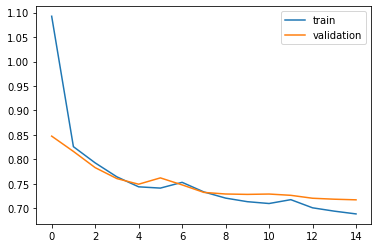

In [0]:
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.legend(['train','validation'])
plt.show()
# plt.savefig("loss_model_GRU_RNN.png")

**Accuracy**

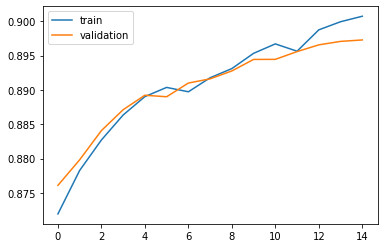

In [0]:
plt.plot(history_GRU.history['acc'])
plt.plot(history_GRU.history['val_acc'])
plt.legend(['train','validation'])
plt.show()

**Predicciones**

In [0]:
model = load_model('model_GRU_RNN_15EPOCH_32BATCH')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

pred_df = pd.DataFrame({'actual_spa': test[:,1], 'actual_eng' : test[:,0], 'predicted' : preds_text})
pd.set_option('display.max_colwidth', 200)

pred_df.head(15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


,actual_spa,actual_eng,predicted
0,¿qué leéis,whatre you reading,what are you reading
1,los estudiantes están en recreo ahora,the students are having a recess now,the are in the now
2,¿dónde conseguiste esta lista,where did you get this list,where did you come this
3,las cosas cambiaron,things changed,things
4,mi hijo quiere ser un golfista profesional,my son wants to be a professional golfer,my boy wants to be a teeth
5,todos lo admiraban,everybody looked up to him,everybody all it
6,el suelo está frío,the floor is cold,the is cold
7,ayer terminé el trabajo,i finished the work yesterday,i took lost the job
8,¿qué tiene que ver eso conmigo,what has that to do with me,what does i have to do with
9,tom llega temprano,toms early,tom came early


<a id="conclusiones"></a>
## Conclusiones

Para concluir, cabe destacar las diferencias observadas en cada uno de los modelos debido a la técnica empleada:

*   Modelo LSTM: llega a alcanzar el 90% de precisión y un 0.675 de pérdida. Además, no se percibe diferencia al introducirle una capa más de LSTM.
*   Modelo SimpleRNN: se obtiene un 40% de precisión y no se minimiza significativamente la función de pérdida.
*   Modelo GRU: alcanza el 90% de precisión, al igual que LSTM. 

Estos resultados se pueden deber a que al ser los datos de entrada, en su mayor parte, secuencias medias-largas, la precisión de LSTM y GRU es muy similar ya que ambas son buenas para este tipo de secuencia. Si las secuencias hubieran sido más largas, entonces sí que se hubiera percibido más diferencia entre LSTM y GRU, siendo mejor emplear LSTM para ello. 

Además, el modelo SimpleRNN no consigue aprender demasiado en las épocas establecidas. Esto puede deberse al problema de desvanecimiento del gradiente (vanishing gradient problem), siendo las secuencias demasiado largas para este tipo de técnica.



